# Neural Network Benchmark Preparations

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we will generate Patchified versions of the processed datasets and save them onto Google Drive. In another notebook, the files will be loaded and used to train models to try and predict the cells

From 013, we know that the best performing patch size seems to be 256. We also know that the best starting conditions should be 100 epochs, and a batch size of either 4 or 8

It will be worthwhile to vary parameters and optimizers for these functions to try find the best performing model

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import getcwd
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

Please ensure the following folders containg images exist:

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_ST

------------------------------------------------------

Then, please ensure a seperate folder with the notebooks and text files exists:

drive > MyDrive > COMP700_Neural_Network_Code

------------------------------------------------------

The first 4 image folders were generated offline by the other notebooks and then uploaded to Google Drive, whereas the next 6 were generated by the notebook 011. The final 2 were generated by 015

## Installs

In [3]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [4]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

from patchify import patchify

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


# Useful functions

In [5]:
from shutil import move

# save to current location, then move to desired location
def saveImages(array, folder, filename):
    count = 0
    temp = ""
    zeroes = "0"
    for image in array:
        count += 1
        temp = str(count)
        zeroes = "0" * (4 - len(temp))
        path = getcwd() + "/" + filename + "_" + zeroes + temp + ".png"
        image = np.clip(image, 0.0, 1.0) # just incase Matplotlib complains
        
        # print(path)

        plt.imsave(path, image)
        x = cv2.imread(path)
        cv2.imwrite(path, x)
    
    print("Images saved successfuly")
    moveImages(filename, folder, count)
###

def moveImages(filename, folder, numFiles):
    count = 0
    temp = ""
    zeroes = "0"
    taskComplete = False
    for root, dirs, files in walk(getcwd()):
        if (not taskComplete):
            for someFile in files:
                if (filename in someFile):
                    # print("Found ya")
                    count += 1
                    move(someFile, folder + "/" + someFile)

                    if (count >= numFiles):
                      taskComplete = True
                      break
    print("Images moved successfully")
###

In [6]:
def getImagePaths(path):
    image_paths = []
    for root, dirs, files in walk(path):
        if (len(files) != 0):
          # print(len(files))
          image_paths.append( root )

    image_paths.sort()

    return image_paths
###

def writeArrayToFile(filename, array):
    with open(filename, 'w') as f:
        for row in array:
            f.write(row + "\n")
###

def generateTxtDoc(training_data_folder, filename):
    if (not exists(filename)):
        image_paths = getImagePaths(training_data_directory + training_data_folder)

        writeArrayToFile(filename, image_paths)
        
        if (exists(filename)):
            print("File created successfully")
        else:
            print("Unable to create file...")
    else:
        print("File already Exists")
###

In [7]:
# returns tuple
def extractDirectoryPaths(path):
    x_directory_locations, y_directory_locations = [], []
    temp = ""

    with open(path) as f:
        lines = f.readlines()
        for item in lines:
            temp = item[ : -1] # remove newline char at end
            if ("X" in temp):
                x_directory_locations.append( temp ) 
            else:
                y_directory_locations.append( temp ) 

    return (x_directory_locations, y_directory_locations)
###

def loadImagePathsFromArray(array):
    image_paths = []

    for path in array:
        for root, dirs, files in walk(path):
            if (len(files) != 0):
                for item in files:
                    image_paths.append(root + "/" + item)

    image_paths.sort()

    return image_paths
###

In [8]:
def patchifyImages(array, patch_size, imageIsMask, isColourImage=True):
    scaler = MinMaxScaler()
    image_dataset, label_dataset = [], []
    count, appendix = 0, 0
    length = len(array)

    for img_path in array:
        count += 1

        if (imageIsMask):
            image = plt.imread(img_path)
            plt.imsave("temp.png", image, cmap='gray')
            image = cv2.imread("temp.png")
        else:
            image = cv2.imread(img_path)

        #Nearest size divisible by our patch size
        SIZE_X = (image.shape[1] // patch_size) * patch_size 
        SIZE_Y = (image.shape[0] // patch_size) * patch_size 

        image = fromarray(image)
        # Crop entire image into desirable shape
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
        image = np.array(image)

        if (count % 50 == 0 or count == 1):
          print("Patchifying ", count, "/", length, " images", sep="")

        #Extract patches from each image
        if (isColourImage):
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        else:
            patches_img = patchify(image, (patch_size, patch_size), step=patch_size) # grayscale patchify
        
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                
                #Use minmaxscaler instead of just dividing by 255. 
                single_patch_img = scaler.fit_transform(
                    single_patch_img.reshape(-1, single_patch_img.shape[-1])
                ).reshape( single_patch_img.shape )
                
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                #Drop the extra unecessary dimension that patchify adds. 
                single_patch_img = single_patch_img[0] 

                # scale up values - don't do this for the NN!
                # img_new = (single_patch_img * 255).astype(int) 
                img_new = single_patch_img

                image_dataset.append(img_new)

                # extract folder path, remove extension, and add a counter
                label_dataset.append( extractRhsString(img_path, "T/")[ : -4] + "_" + str(appendix) )
                appendix += 1

        appendix = 0 # reset

    print("Patchify process complete!")

    if (exists("temp.png")):
        remove("temp.png")

    return image_dataset, label_dataset
###

In [9]:
from tensorflow import keras
from keras.utils import array_to_img

def display(display_list, title=[], figsize=(15, 15)):
    plt.figure(figsize=figsize)

    # update if title not provided
    if (len(title) == 0):
      title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i], wrap=True)
        
        # handle 2D and 3D images
        if (len(display_list[i].shape) == 3 ):
            plt.imshow( array_to_img(display_list[i]), cmap="gray")
        else:
            plt.imshow( display_list[i], cmap="gray")
            
        plt.axis('off')
    plt.tight_layout() # prevents overlap
    plt.show()
###


In [10]:
# create directories for work we create
def tryMakeDirectories(current_directory, myList):
    path = ""
    for item in myList:
        # initialize
        if (path == ""):
            path = item
        else:
            path = path + "/" + item
            
        try:
            # join comes from os.path
            mkdir( join(current_directory, path) )
        except FileExistsError:
            # print("Folder already exists!")
            pass
        except:
            print("Unknown Error Encountered...")
###

In [11]:
def extractRhsString(string, symbol):
    index = string.rfind(symbol)
    return string[ index + len(symbol) : ]
###

# Text File Generation

In this section of the notebook, the author will traverse the images loaded on Google Drive, and generate text files for the models to use. The text files will then be saved in the same destination as the Neural Network notebooks

In [12]:
from os import getcwd, walk
from os.path import exists

In [13]:
getcwd()

'/content'

In [14]:
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

In [15]:
training_data_directory

'/content/drive/MyDrive/COMP700_Images/'

Let's do a sanity check before continuing, to ensure our images are consistent:

In [16]:
# "COMP700_Processed_Training_ST"
training_data_folder = "COMP700_Processed_Training_ST"

st_x_dirs = []
st_y_dirs = []
st_x_length = []
st_y_length = []

for root, dirs, files in walk(training_data_directory + training_data_folder):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            st_x_dirs.append( extractRhsString(root2, "ST/") )
            st_x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            st_y_dirs.append( extractRhsString(root2, "ST/") )
            st_y_length.append(len(files2))

In [17]:
print(st_x_length)
print(st_y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(st_x_dirs)
# print(st_y_dirs)


[115, 115, 84, 84, 92, 92, 300, 300, 92, 92, 1764, 1764, 1376, 1386, 48, 48]
[115, 115, 84, 84, 92, 92, 300, 300, 92, 92, 1764, 1764, 1376, 1386, 48, 48]



In [18]:
# "COMP700_Processed_Training_GT"
training_data_folder = "COMP700_Processed_Training_GT"

gt_x_dirs = []
gt_y_dirs = []
gt_x_length = []
gt_y_length = []

for root, dirs, files in walk(training_data_directory + training_data_folder):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            gt_x_dirs.append( extractRhsString(root2, "GT/") )
            gt_x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            gt_y_dirs.append( extractRhsString(root2, "GT/") )
            gt_y_length.append(len(files2))


In [19]:
print(gt_x_length)
print(gt_y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(gt_x_dirs)
# print(gt_y_dirs)


[2, 2, 5, 8, 50, 50, 9, 9, 150, 65, 15, 19, 8, 49, 8, 28, 33, 18, 30, 20]
[2, 2, 5, 8, 50, 50, 9, 9, 150, 65, 15, 19, 8, 49, 8, 28, 33, 18, 30, 20]



We have already generated the text files to use from 011 - so instead, we can just read that data in!

# Loading GT and ST Training Data

Here, we can read in the contents of our desired text files and prepare them to be shuffled

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
from os import getcwd, walk

In [22]:
google_drive_path = "/drive/MyDrive"
text_file_location = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"

Extract and load Image

In [23]:
filename = "processed_training_paths_gt.txt"
gt_x_image_paths, gt_y_image_paths = extractDirectoryPaths(text_file_location + filename)

gt_x_images = loadImagePathsFromArray(gt_x_image_paths)
gt_y_images = loadImagePathsFromArray(gt_y_image_paths)

if (len(gt_x_images) == len(gt_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [24]:
filename = "processed_training_paths_st.txt"
st_x_image_paths, st_y_image_paths = extractDirectoryPaths(text_file_location + filename)

st_x_images = loadImagePathsFromArray(st_x_image_paths)
st_y_images = loadImagePathsFromArray(st_y_image_paths)

if (len(st_x_images) == len(st_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [25]:
print("There are", len(st_x_images), "ST images and", len(gt_x_images), "GT images")

There are 7752 ST images and 578 GT images


# Crop and Patchify GT images

Recall the table from 011, where we calculated the breakdown of images..

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

We desire 2000 images for our processed data of patch size 256. That should be (2 * B) --> 100 X images and 24 Y images

We could force 13 images to come from each folder - but this may not be representative of the total data available. 

Instead, we will attempt to patchify all the images in our dataset, shuffle them, and save them. We can then bring them in and experiment with what the largest quantity for our model is.

Unfortunately, processing 578 images for X and Y is causing it to crash... let's try 350 instead?

In [ ]:
scaler = MinMaxScaler()

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    gt_x_images, gt_y_images, test_size=0.1, random_state=42
)

In [ ]:
patch_size = 256
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_train[0:350], patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/350 images
Patchifying 50/350 images
Patchifying 100/350 images
Patchifying 150/350 images
Patchifying 200/350 images
Patchifying 250/350 images
Patchifying 300/350 images
Patchifying 350/350 images
Patchify process complete!

3199 images exist


In [ ]:
patch_size = 256
gt_y_patchify_images, gt_y_patchify_labels = patchifyImages(y_train[0:350], patch_size, imageIsMask=False)

print()
print(len(gt_y_patchify_images), "images exist")

Patchifying 1/350 images
Patchifying 50/350 images
Patchifying 100/350 images
Patchifying 150/350 images
Patchifying 200/350 images
Patchifying 250/350 images
Patchifying 300/350 images
Patchifying 350/350 images
Patchify process complete!

3199 images exist


Shuffle data together:

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    gt_x_patchify_images, gt_y_patchify_images, test_size=0.33, random_state=42
)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

2143
2143
1056
1056


## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

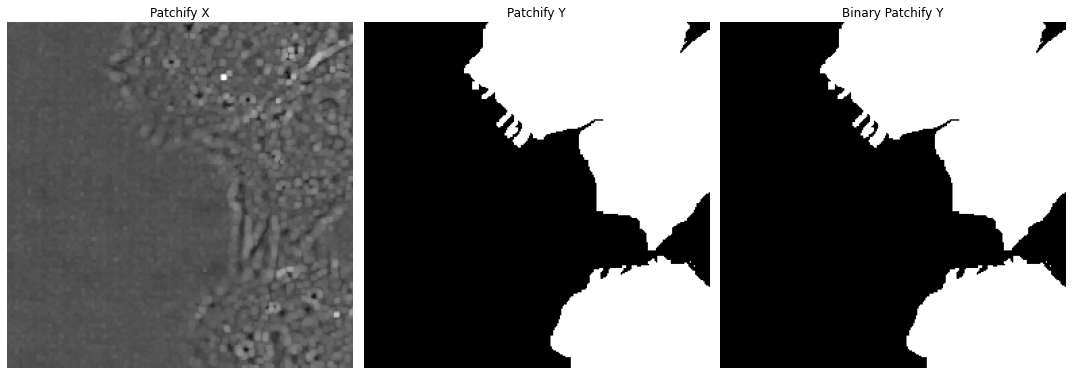

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

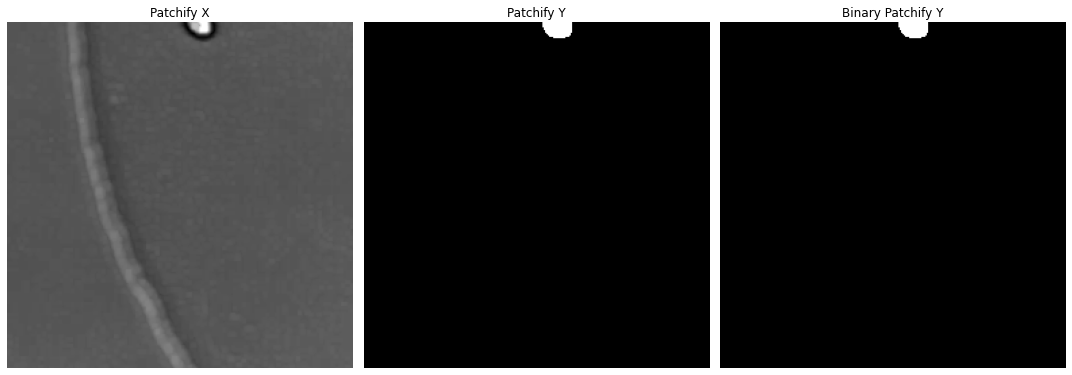

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In [ ]:
directory_list = ["COMP700_Patchify_Images_Processed_Images_GT", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_Processed_Images_GT", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_Processed_Images_GT", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_Processed_Images_GT", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_Processed_Images_GT/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_Processed_Images_GT/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_Processed_Images_GT/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_Processed_Images_GT/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


# Crop and Patchify ST images

Recall the table from 011, where we calculated the breakdown of images..

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

We desire 2000 images for our processed data of patch size 256. That should be (2 * B) --> 100 X images and 24 Y images

We could force 13 images to come from each folder - but this may not be representative of the total data available. 

Instead, we will attempt to patchify all the images in our dataset, shuffle them, and save them. We can then bring them in and experiment with what the largest quantity for our model is.

Unfortunately, processing ~7000 images for X and Y will definitely cause the program to crash, if 400 is not even possible... 350 is also failing... let's try 300 instead?

In [26]:
scaler = MinMaxScaler()

In [27]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    st_x_images, st_y_images, test_size=0.1, random_state=42
)

In [28]:
patch_size = 256
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_train[0:300], patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/300 images
Patchifying 50/300 images
Patchifying 100/300 images
Patchifying 150/300 images
Patchifying 200/300 images
Patchifying 250/300 images
Patchifying 300/300 images
Patchify process complete!

3270 images exist


In [29]:
patch_size = 256
st_y_patchify_images, st_y_patchify_labels = patchifyImages(y_train[0:300], patch_size, imageIsMask=False)

print()
print(len(st_y_patchify_images), "images exist")

Patchifying 1/300 images
Patchifying 50/300 images
Patchifying 100/300 images
Patchifying 150/300 images
Patchifying 200/300 images
Patchifying 250/300 images
Patchifying 300/300 images
Patchify process complete!

3270 images exist


Shuffle data together:

In [30]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    st_x_patchify_images, st_y_patchify_images, test_size=0.33, random_state=42
)

In [31]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

2190
2190
1080
1080


## Update Mask Classes from Multiclass to Binary class

In [32]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [33]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

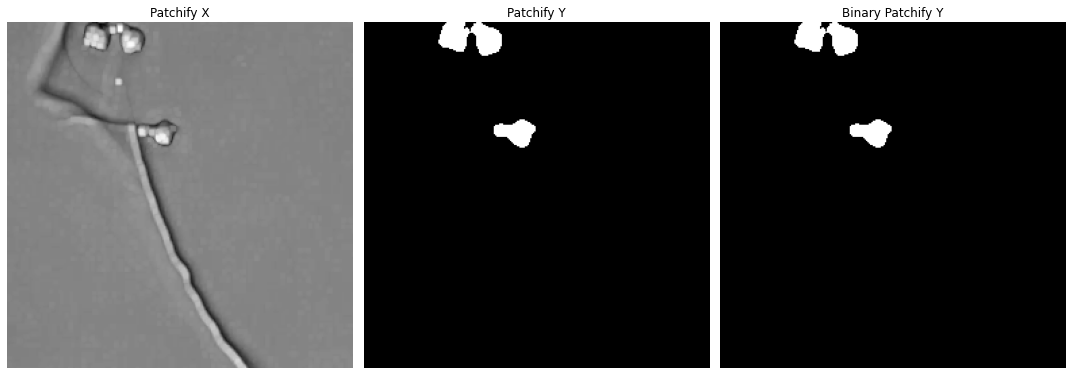

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

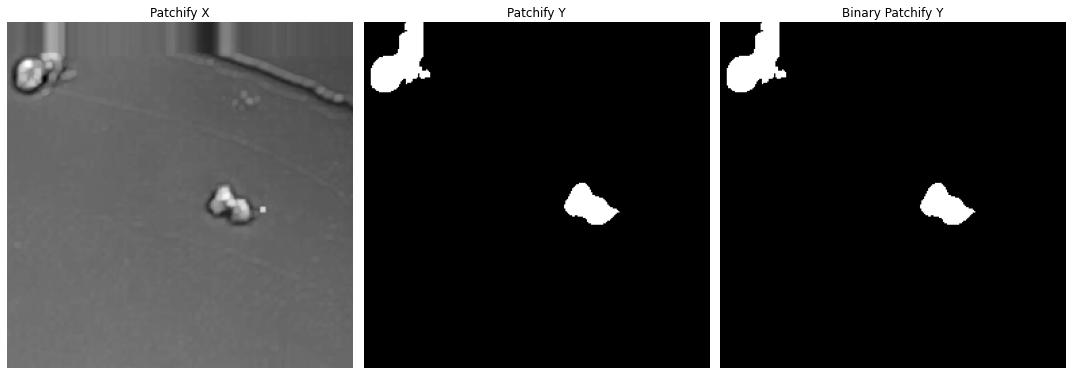

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In [ ]:
directory_list = ["COMP700_Patchify_Images_Processed_Images_ST", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_Processed_Images_ST", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_Processed_Images_ST", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_Processed_Images_ST", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_Processed_Images_ST/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_Processed_Images_ST/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [37]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_Processed_Images_ST/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [34]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_Processed_Images_ST/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


# Conclusion

I am now in a position where I can load those pictures in and train a neural network on them!